In [1]:
import jax.numpy as jnp
import chromatix.functional as cf
import matplotlib.pyplot as plt
from chromatix.ops import init_plane_resample
from jax import Array
from jax.typing import ArrayLike
import jax
from flax.struct import PyTreeNode
import numpy as np
import sys
from chromatix.utils.utils import sigmoid_taper
sys.path.append("../")
from sample import single_bead_sample
from sample import R, Rx, Ry, Rz
from tensor_tomo import thick_polarised_sample
from chromatix.utils.initializers import rectangular_microlens_array_amplitude_and_phase

In [2]:
# Simulation settings
size = (4.55, 11.7, 11.7) # from paper
spacing = 0.065 # [mum], from paper
wavelength = 0.405 # [mum], from paper
n_background = 1.33
n_bead = jnp.array([1.44, 1.40, 1.37])  # z y x
polarisation = cf.linear(0) # x-polarised light
k0 = 2 * jnp.pi / wavelength
bead_radius = 1.5 # [mum]
NA = 0.8

In [23]:
def Rmat(theta_z, theta_y, theta_x, inv: bool = False):
    if inv:
        return Rz(theta_z) @ Ry(theta_y) @ Rx(theta_x)
    else:
        return R(theta_z, theta_y, theta_x)

def paper_sample() -> Array:
    # Calculating shape
    shape = np.around((np.array(size) / spacing)).astype(int) # without around becomes 1 less!

    # center of pixel is our coordinate
    z = jnp.linspace(1/2*spacing, size[0] - 1/2 * spacing, shape[0])
    y = jnp.linspace(size[1] - 1/2 * spacing, 1/2 * spacing, shape[1])
    x = jnp.linspace(1/2*spacing, size[2] - 1/2 * spacing, shape[2])
    grid = jnp.stack(jnp.meshgrid(z, y, x, indexing="ij"), axis=-1) 

    # Position of each bead, with radius 
    bead_pos = jnp.array([[size[0] / 2, 8.85, 2.85],
                      [size[0] / 2, 8.85, 8.85],
                      [size[0] / 2, 2.85, 2.85],
                      [size[0] / 2, 2.85, 8.85]])
    rotation = jnp.array([[0.0, jnp.pi/2, 0.0], 
                      [0.0, 0.0,0.0],
                      [0.0, 0.0, jnp.pi/2], 
                      [jnp.pi/4, jnp.pi/4, jnp.pi/4]])


    permitivitty = jnp.zeros((*shape, 1, 3, 3))

    # Adding each bead
    for pos, orientation in zip(bead_pos, rotation):
        # Making bead and background
        bead_permitivitty = Rmat(*orientation, inv=True).T @ jnp.diag(n_bead**2) @ Rmat(*orientation, inv=True)
        background_permitivitty = jnp.eye(3) * n_background**2

        # Mask
        mask = jnp.sum((grid - pos)**2, axis=-1) < bead_radius ** 2

        # Making sample
        permitivitty += (k0**2 * jnp.where(
            mask[..., None, None, None], background_permitivitty - bead_permitivitty, jnp.zeros((3, 3))
        ))

    return permitivitty

potential = paper_sample()



In [24]:
class PolScope(PyTreeNode):
    # Initial field & sample
    shape: tuple[int, int] = (180, 180)
    spacing: float = 0.065  # [mum], 4 nodes / wavelength
    wavelength: float = 0.405  # [mum]

    # universal compensator
    swing: float = 2* jnp.pi * 0.03

    # Condensor
    condenser_f: float = 3333
    condenser_n: float = 1.52
    condenser_NA: float = 1.4

    # objective lens
    objective_f: float = 3333  # [mum]
    objective_n: float = 1.0  # oil immersion
    objective_NA: float = 1.4  # oil immersion

    # tube lens
    tube_f: float = 200_000
    tube_n: float = 1.0
    tube_NA: float = 1.0

    # MLA
    mla_n: float = 1.0
    mla_f: float = 2500
    mla_radius: float = 50
    mla_separation: float = 100
    mla_n_y: float = 15
    mla_n_x: float = 15

    # Camera
    camera_shape: tuple[int, int] = (240, 240)  # (2048, 2048)
    camera_pitch: float = 6.5  # [mum]


def universal_compensator_modes(swing: float) -> Array:
    uc_modes = jnp.array(
        [
            [jnp.pi / 2, jnp.pi],
            [jnp.pi / 2 + swing, jnp.pi],
            [jnp.pi / 2, jnp.pi + swing],
            [jnp.pi / 2, jnp.pi - swing],
            [jnp.pi / 2 - swing, jnp.pi],
        ]
    )
    # Universal compensator works on fields, so we use a dummy field.
    field = cf.plane_wave((1, 1), 1, 1, amplitude=cf.linear(0.0))
    field = jax.vmap(cf.universal_compensator, in_axes=(None, 0, 0))(field, uc_modes[:, 0], uc_modes[:, 1])
    amplitudes = field.u.squeeze()

    return amplitudes

scope = PolScope()

In [25]:
# Getting the modes 
modes = universal_compensator_modes(2*jnp.pi * 0.03)
print(jnp.around(modes, 2))

[[ 0.  +0.j   -0.35-0.j    0.  -0.35j]
 [ 0.  +0.j   -0.39-0.j    0.  -0.32j]
 [ 0.  +0.j   -0.35-0.03j -0.03-0.35j]
 [ 0.  +0.j   -0.35+0.03j  0.03-0.35j]
 [ 0.  +0.j   -0.32-0.j   -0.  -0.39j]]


In [26]:
# Field I - sample field

field = cf.objective_point_source(
    scope.shape,
    dx=scope.spacing,
    spectrum=scope.wavelength,
    z=scope.condenser_f,
    f=scope.condenser_f,
    n=scope.condenser_n,
    NA=scope.condenser_NA,
    amplitude=modes[3],
)

#field = cf.plane_wave(scope.shape, scope.spacing, scope.wavelength, amplitude=cf.linear(0.0))


# Adding a little apodisation
#field = field.replace(u = field.u * sigmoid_taper((field.shape[1], field.shape[2]), 4))

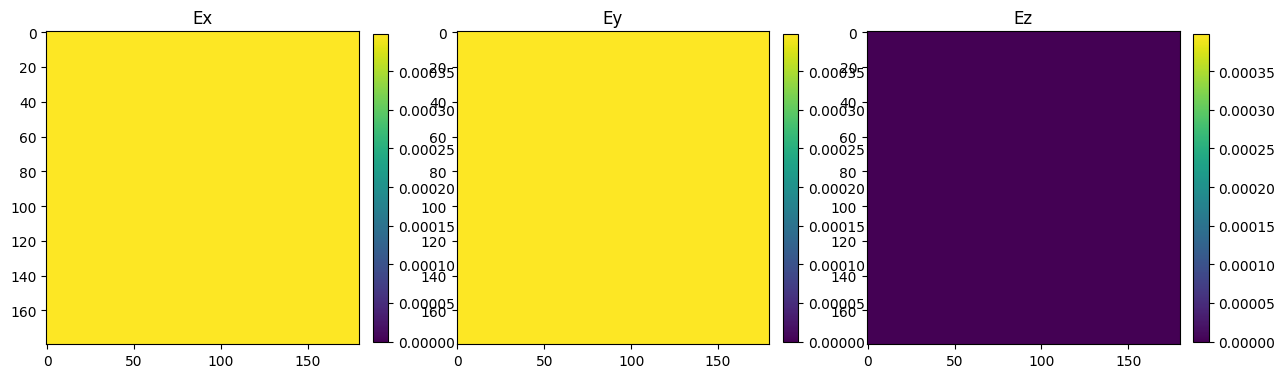

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(field.amplitude.squeeze()[..., 2], vmin=0, vmax=field.amplitude.max())
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(field.amplitude.squeeze()[..., 1], vmin=0, vmax=field.amplitude.max())
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(field.amplitude.squeeze()[..., 0], vmin=0, vmax=field.amplitude.max())
plt.colorbar(fraction=0.045, pad=0.04)

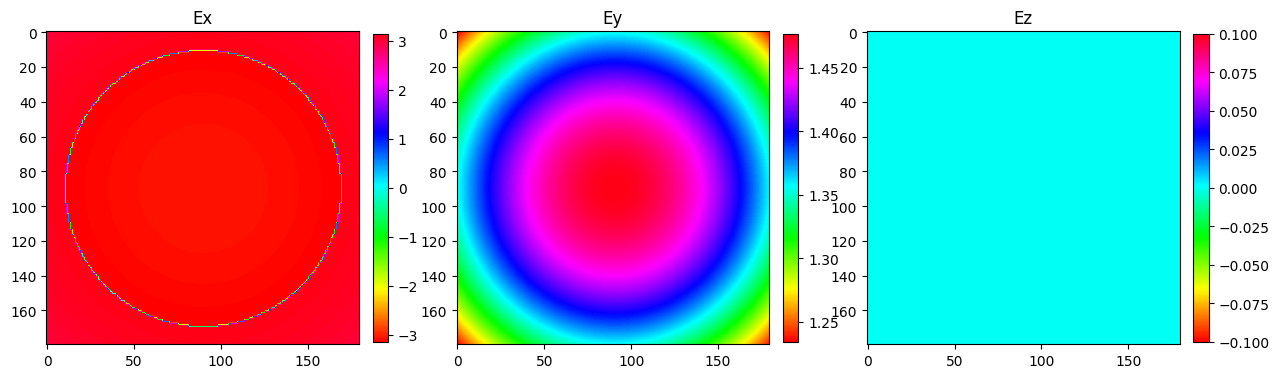

In [28]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(field.phase.squeeze()[..., 2], cmap="hsv")
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(field.phase.squeeze()[..., 1], cmap="hsv")
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(field.phase.squeeze()[..., 0], cmap="hsv")
plt.colorbar(fraction=0.045, pad=0.04)

In [29]:
field = cf.objective_point_source(
    scope.shape,
    dx=scope.spacing,
    spectrum=scope.wavelength,
    z=scope.condenser_f,
    f=scope.condenser_f,
    n=scope.condenser_n,
    NA=scope.condenser_NA,
    amplitude=modes[3],
)

# Adding a little apodisation
field = thick_polarised_sample(
            field, potential, 1.33, 0.065, NA=0.8
        )

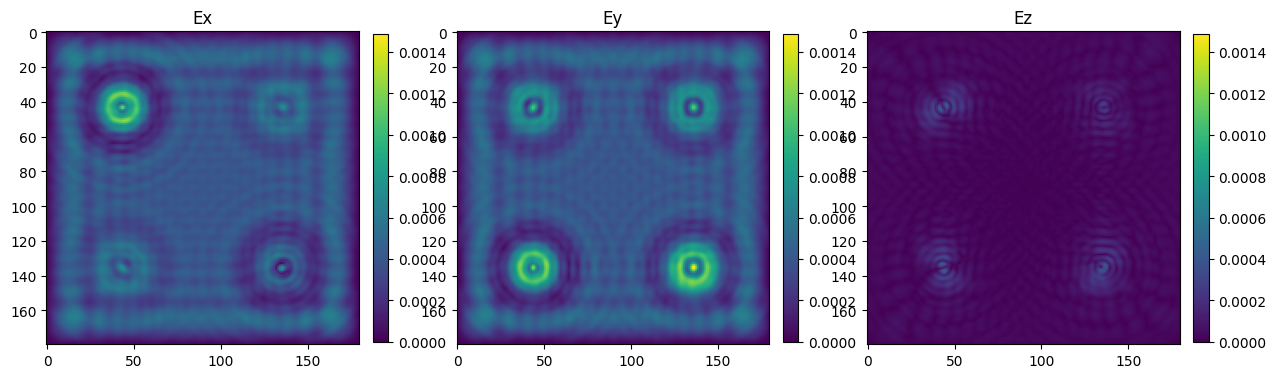

In [30]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(field.amplitude.squeeze()[..., 2], vmin=0, vmax=field.amplitude.max())
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(field.amplitude.squeeze()[..., 1], vmin=0, vmax=field.amplitude.max())
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(field.amplitude.squeeze()[..., 0], vmin=0, vmax=field.amplitude.max())
plt.colorbar(fraction=0.045, pad=0.04)

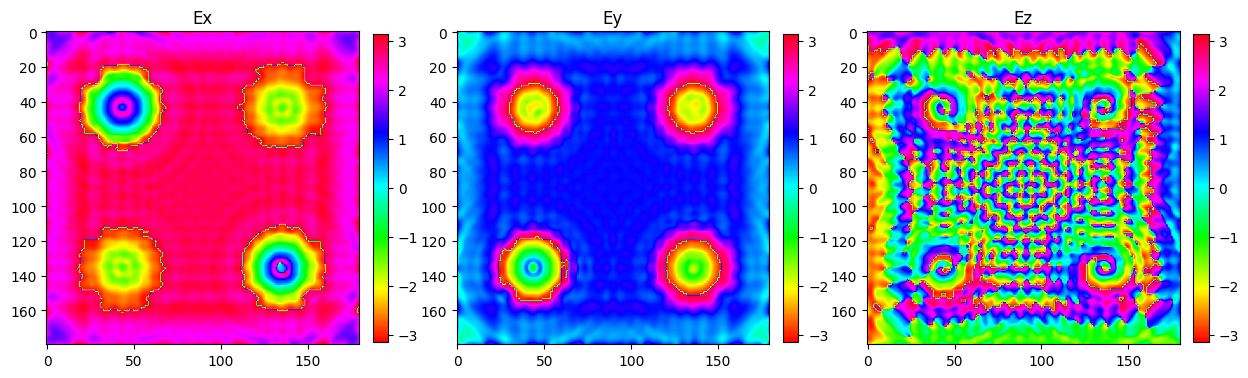

In [31]:
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.title("Ex")
plt.imshow(field.phase.squeeze()[..., 2], cmap="hsv")
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(132)
plt.title("Ey")
plt.imshow(field.phase.squeeze()[..., 1], cmap="hsv")
plt.colorbar(fraction=0.045, pad=0.04)

plt.subplot(133)
plt.title("Ez")
plt.imshow(field.phase.squeeze()[..., 0], cmap="hsv")
plt.colorbar(fraction=0.045, pad=0.04)

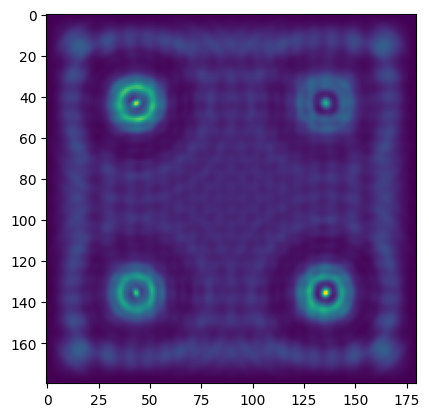

In [32]:
plt.imshow(field.intensity.squeeze())

In [33]:
field = cf.ff_lens(field, scope.objective_f, scope.objective_n, scope.objective_NA)
field = cf.right_circular_polarizer(field)
field = cf.ff_lens(field, scope.tube_f, scope.tube_n, scope.tube_NA)

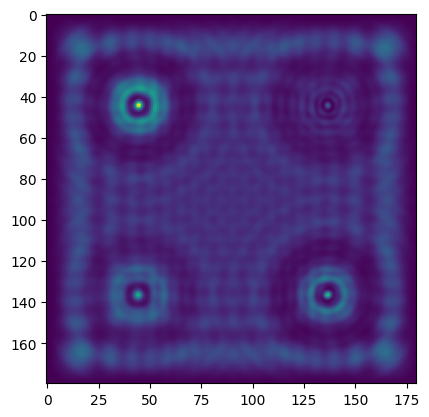

In [34]:
plt.imshow(field.intensity.squeeze())

In [19]:
field = cf.rectangular_microlens_array(
            field,
            n=scope.mla_n,
            f=scope.mla_f,
            num_lenses_height=scope.mla_n_y,
            num_lenses_width=scope.mla_n_x,
            radius=scope.mla_radius,
            separation=scope.mla_separation,
            block_between=True,
        )

In [20]:
field = cf.transfer_propagate(field, scope.mla_f, scope.mla_n, 512, mode="same")

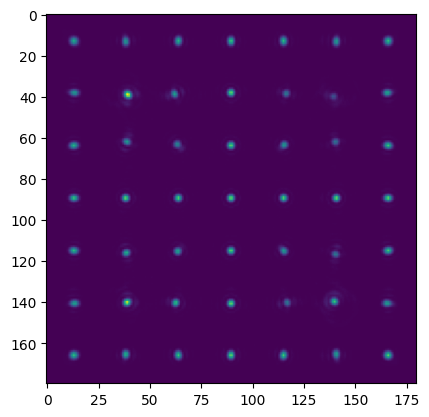

In [22]:
plt.imshow(field.intensity.squeeze())

In [ ]:



        # Illumination


        # sample - we have some power gain, we should probably renormalise?
        

        # propagation over - half / sample as imaging is focused in center of sample
        field = cf.transfer_propagate(
            field, -z_sample / 2, scope.objective_n, 512, mode="same"
        )

        # Imaging
        # Objective lens - polariser - tube lens
       
        # MLA and imaging
        
        
      

        camera = init_plane_resample(scope.camera_shape, scope.camera_pitch)(
            field.intensity.squeeze(0), field.dx.squeeze()
        )
        return field, camera.squeeze()

    


# %% Running
scope = PolScope()

potential = single_bead_sample(
    1.52,
    jnp.array([1.37, 1.44, 1.44]),
    jnp.array([0, 1/4 * jnp.pi, 0]),
    radius=10.0,
    shape=(256, 256, 256),
    spacing=0.546 / 2,
    k0=2 * jnp.pi / 0.546,
)[:-1, :-1, :-1, None]


field, image = scope.forward(
    scope.universal_compensator_modes(scope.swing)[1], potential
)